# Bi-variate Analysis

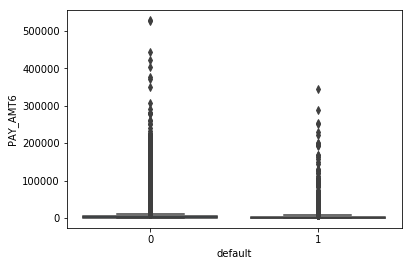

In [0]:
sns.boxplot(x='default',y= 'PAY_AMT6',data=data)

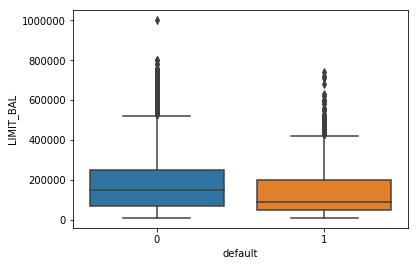

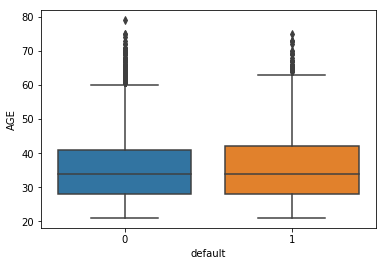

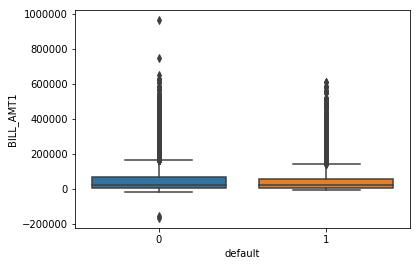

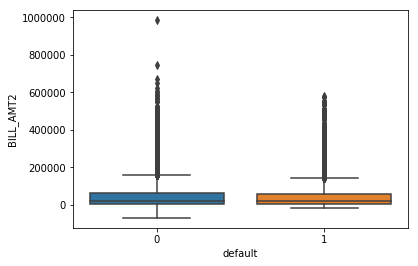

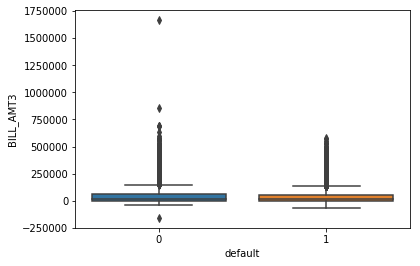

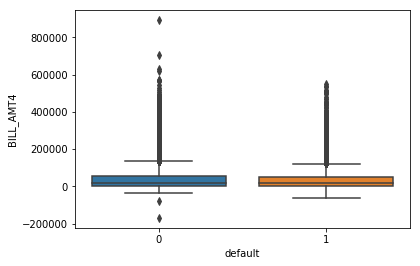

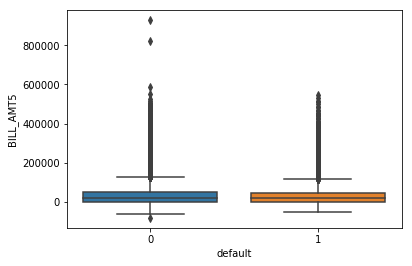

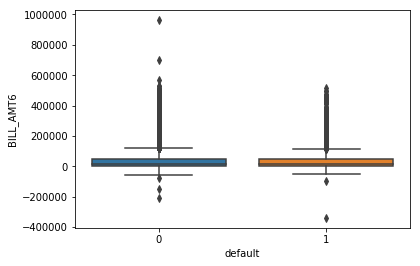

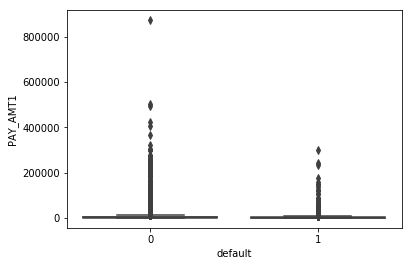

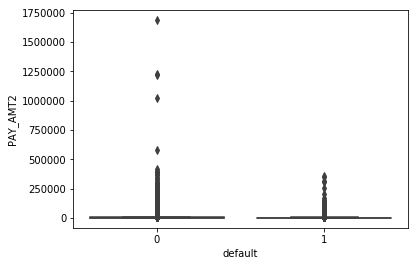

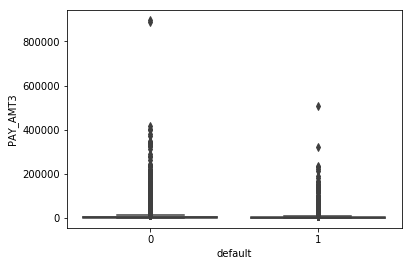

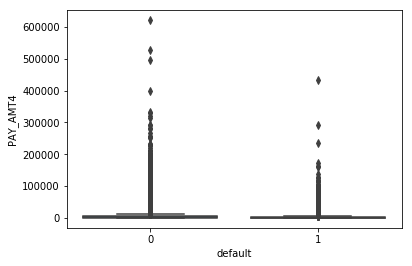

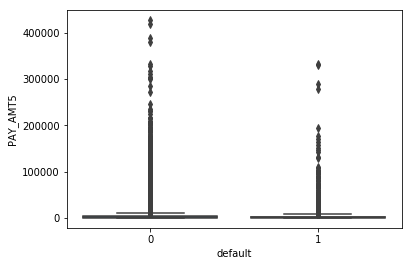

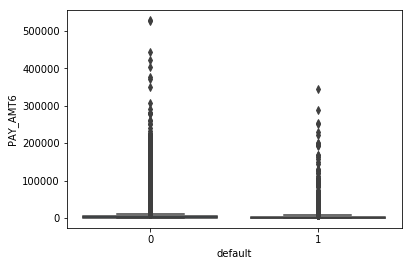

In [0]:
for i in num:
  sns.boxplot(x='default',y = i,data=data)
  plt.show()

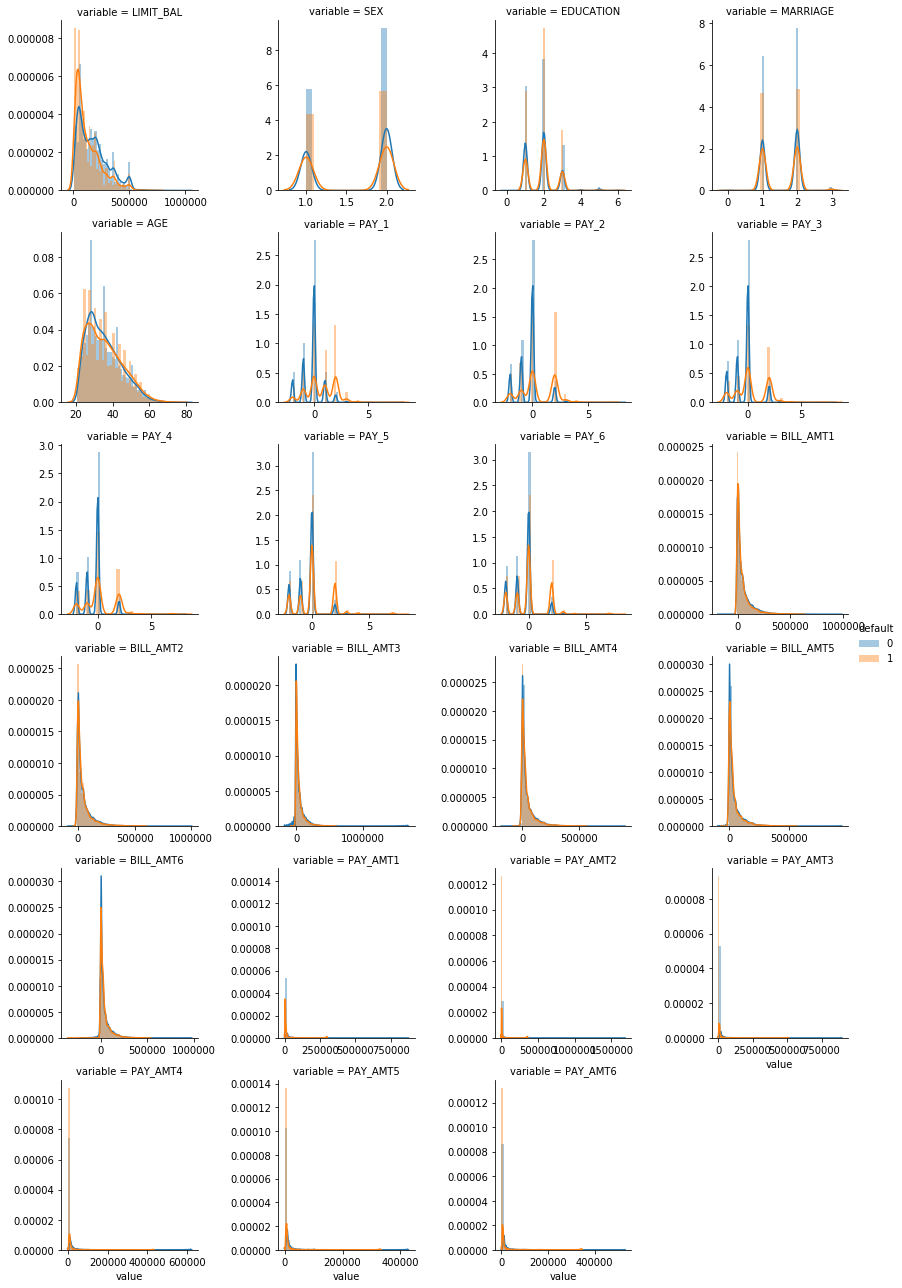

In [0]:
output = 'default'

# Let's do a little EDA
cols = [ f for f in data.columns if data.dtypes[ f ] != "object"]
#cols.remove( "ID")
cols.remove( output )

f = pd.melt( data, id_vars=output, value_vars=cols)
g = sns.FacetGrid( f, hue=output, col="variable", col_wrap=4, sharex=False, sharey=False )
g = g.map( sns.distplot, "value", kde=True).add_legend()

In [0]:
def getColumnsNames(prefix):
    return [prefix+str(x) for x in range(1,7)]

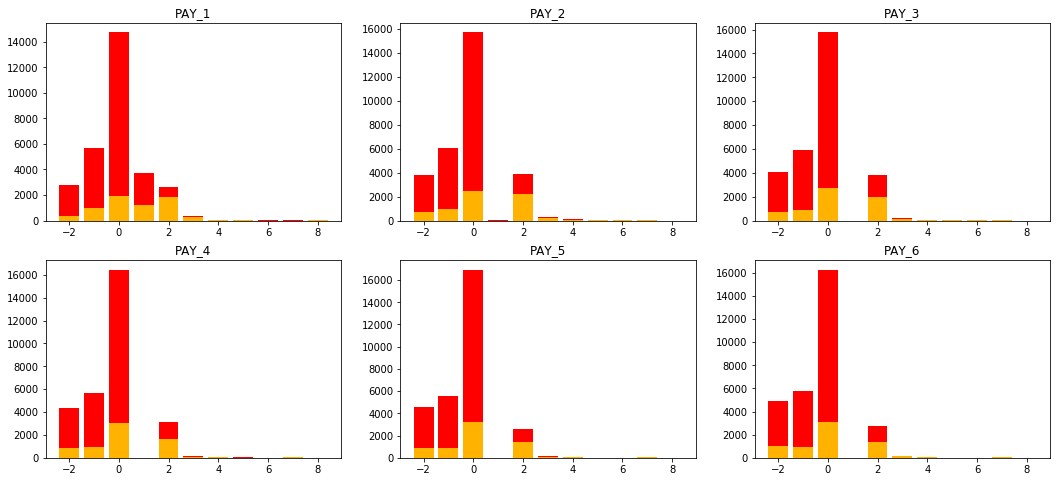

In [0]:
pay_status_columns = getColumnsNames('PAY_')
figure, ax = plt.subplots(2,3)
figure.set_size_inches(18,8)


for i in range(len(pay_status_columns)):
    row,col = int(i/3), i%3

    d  = data[pay_status_columns[i]].value_counts()
    x = data[pay_status_columns[i]][(data['default']==1)].value_counts()
    ax[row,col].bar(d.index, d, align='center', color='red')
    ax[row,col].bar(x.index, x, align='center', color='yellow', alpha=0.7)
    ax[row,col].set_title(pay_status_columns[i])
   


    
plt.show()

The above barplot shows for each month payment status the count of defaulters and non defaulters

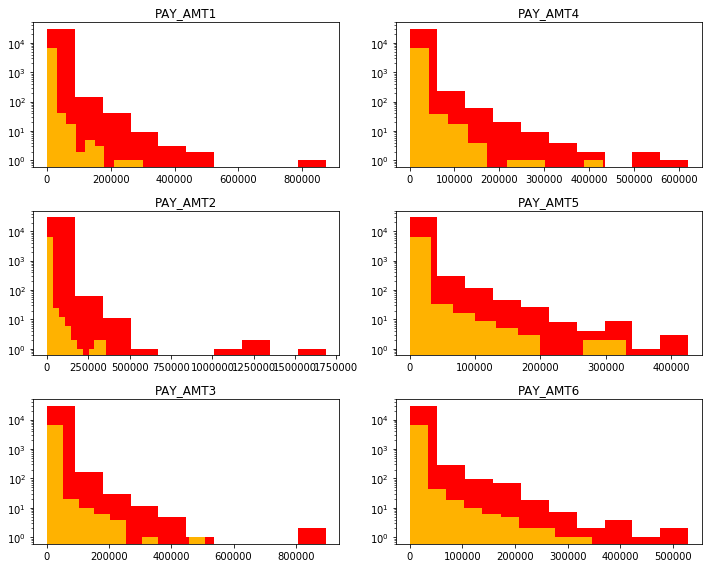

In [0]:
pay_amt_columns = getColumnsNames('PAY_AMT')
figure, ax = plt.subplots(3,2)
figure.set_size_inches(10,8)


for i in range(len(pay_status_columns)):
    row,col =  i%3, int(i/3)
   
    ax[row,col].hist(data[pay_amt_columns[i]], color ='red')
    ax[row,col].hist(data[pay_amt_columns[i]][(data['default']==1)],color='yellow',alpha = 0.7)
    ax[row,col].set_title(pay_amt_columns[i])
    #adding scaling to make the graph more helpful
    ax[row,col].set_yscale('log', nonposy='clip')
plt.tight_layout()
plt.show()

In [0]:
df = data.copy()

In [0]:
df = pd.get_dummies(df,columns=['EDUCATION','MARRIAGE'])

In [0]:
df.head()

,LIMIT_BAL,SEX,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,EDUCATION_0,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_0,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
2,120000,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1,0,0,1,0,0,0,0,0,0,1,0
3,90000,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0,0,0,1,0,0,0,0,0,0,1,0
4,50000,2,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0,0,1,0,0,0,0,0,1,0,0
5,50000,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0,0,0,1,0,0,0,0,0,1,0,0


In [0]:

df.PAY_1=df.PAY_1 + 2


In [0]:
pay=['PAY_2','PAY_3','PAY_4','PAY_5','PAY_6']
for i in pay:
    df[i]=df[i]+2


## Information and weight of evidence.


In [0]:
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string

In [0]:
max_bin = 30
force_bin = 3

# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    df2 = notmiss.groupby('X',as_index=True)
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.sum().Y.index
    d3["MAX_VALUE"] = d3["MIN_VALUE"]
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    d3["EVENT_RATE"] = d3.EVENT/d3.COUNT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.COUNT
    d3["DIST_EVENT"] = d3.EVENT/d3.sum().EVENT
    d3["DIST_NON_EVENT"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["IV"] = (d3.DIST_EVENT-d3.DIST_NON_EVENT)*np.log(d3.DIST_EVENT/d3.DIST_NON_EVENT)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'DIST_EVENT','DIST_NON_EVENT','WOE', 'IV']]
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    return(d3)


def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    iv = iv.reset_index()
    return(iv_df,iv)

In [0]:
final_iv, IV = data_vars(df,df.default)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:80: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log


In [0]:
final_iv

,VAR_NAME,MIN_VALUE,MAX_VALUE,COUNT,EVENT,EVENT_RATE,NONEVENT,NON_EVENT_RATE,DIST_EVENT,DIST_NON_EVENT,WOE,IV
0,LIMIT_BAL,10000,30000,4081,1463,0.358491,2618,0.641509,0.220464,0.112053,0.676765,1.753614e-01
1,LIMIT_BAL,40000,50000,3595,977,0.271766,2618,0.728234,0.147227,0.112053,0.273008,1.753614e-01
2,LIMIT_BAL,60000,80000,3123,806,0.258085,2317,0.741915,0.121459,0.099170,0.202742,1.753614e-01
3,LIMIT_BAL,90000,120000,3013,749,0.248589,2264,0.751411,0.112869,0.096901,0.152538,1.753614e-01
4,LIMIT_BAL,130000,160000,3282,651,0.198355,2631,0.801645,0.098101,0.112609,-0.137923,1.753614e-01
5,LIMIT_BAL,170000,200000,3284,573,0.174482,2711,0.825518,0.086347,0.116033,-0.295500,1.753614e-01
6,LIMIT_BAL,210000,260000,3426,567,0.165499,2859,0.834501,0.085443,0.122368,-0.359181,1.753614e-01
7,LIMIT_BAL,270000,360000,3720,556,0.149462,3164,0.850538,0.083785,0.135422,-0.480137,1.753614e-01
8,LIMIT_BAL,370000,1000000,2476,294,0.118740,2182,0.881260,0.044304,0.093392,-0.745730,1.753614e-01
9,SEX,1,1,11888,2873,0.241672,9015,0.758328,0.432942,0.385850,0.115154,9.179578e-03


In [0]:
IV.sort_values('IV')

,VAR_NAME,IV
7,EDUCATION_0,3.591632e-07
4,BILL_AMT4,5.661074e-05
3,BILL_AMT3,1.940948e-04
13,EDUCATION_6,2.690088e-04
5,BILL_AMT5,4.367304e-04
18,MARRIAGE_3,5.234028e-04
2,BILL_AMT2,8.651334e-04
15,MARRIAGE_0,1.377427e-03
0,AGE,1.528468e-03
6,BILL_AMT6,2.050740e-03


## **Outlier** analysis

In [0]:
from sklearn.ensemble import IsolationForest
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor

Two functions that statistically identify outliers in pandas series using std and IQR.

In [0]:
def out_std(s, nstd=3.0, return_thresholds=False):
  data_mean, data_std = s.mean(), s.std()
  cut_off = data_std * nstd
  lower, upper = data_mean - cut_off, data_mean + cut_off
  if return_thresholds:
     return lower, upper
  else:
     return [True if x < lower or x > upper else False for x in s]

In [0]:
def out_iqr(s, k=1.5, return_thresholds=False):
  # calculate interquartile range
    q25, q75 = np.percentile(s, 25), np.percentile(s, 75)
    iqr = q75 - q25
    # calculate the outlier cutoff
    cut_off = iqr * k
    lower, upper = q25 - cut_off, q75 + cut_off
    if return_thresholds:
        return lower, upper
    else: # identify outliers
        return [True if x < lower or x > upper else False for x in s]

In [0]:
outlier_mask = out_std(data['LIMIT_BAL'], nstd=3.0)
outlier_mask[:10]

[False, False, False, False, False, False, False, False, False, False]

In [0]:
data['LIMIT_BAL'][outlier_mask]

ID
13        630000
434       580000
452       600000
528       620000
556       630000
738       610000
812       700000
1096      670000
1232      680000
1348      630000
1905      580000
1993      580000
2198     1000000
2223      600000
2352      580000
3315      600000
3403      710000
3406      560000
3690      710000
3734      750000
4034      710000
4252      580000
4604      750000
4755      680000
4860      640000
5334      580000
5809      640000
5879      710000
6080      670000
6638      610000
          ...   
23894     620000
24224     580000
24321     780000
24409     620000
24554     600000
24684     590000
24687     730000
25127     740000
25487     600000
26033     650000
26113     720000
26137     600000
26177     670000
26228     610000
26873     560000
26922     720000
27098     580000
27460     700000
27558     730000
28562     640000
28716     780000
28823     590000
29012     580000
29137     610000
29405     610000
29572     570000
29741     620000
29862     6

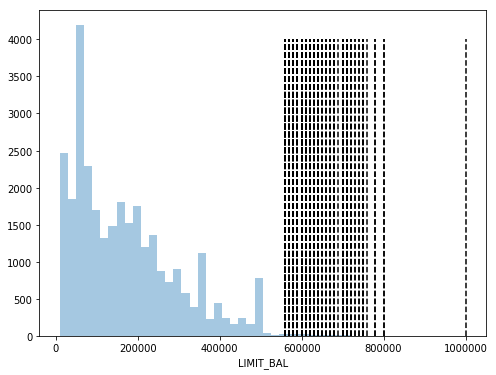

In [0]:
plt.figure(figsize=(8,6))
sns.distplot(data['LIMIT_BAL'], kde=False);
plt.vlines(data['LIMIT_BAL'][outlier_mask], ymin=0, ymax=4000, linestyles='dashed')

In [0]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score,auc